In [69]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
from matplotlib.collections import EllipseCollection

from scipy.signal import hilbert

import pandas as pd

import py.continuum1d as continuum1d
c1d = continuum1d.continuum1d()

from py.params import setParams
from py.analysis import computeFPs, checkFixPtsStability, violationType, a_jkValues, lmbd
from py.turings import checkStability
from py.funcs import getSwitchIndex

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

1d Model initialised.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
# explicit function to normalize array (for visualisation reasons - very helpful!)
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [70]:
b1_lats = pd.read_csv('phase_lats/ee047_ii001_b.csv')
b2_lats = pd.read_csv('phase_lats/ee04_ii_minus014_b.csv')
b3_lats = pd.read_csv('phase_lats/ee02_ii_minus025_b.csv')

all_b_dfs = [b1_lats, b2_lats, b3_lats]

In [71]:
tau1_lats = pd.read_csv('phase_lats/ee047_ii001_tau.csv')
tau2_lats = pd.read_csv('phase_lats/ee04_ii_minus014_tau.csv')
tau3_lats = pd.read_csv('phase_lats/ee02_ii_minus025_tau.csv')

all_tau_dfs = [tau1_lats, tau2_lats, tau3_lats]

In [72]:
def compute_avg(all_dfs):
    #all_b_dfs = [b1_lats, b2_lats, b3_lats]
    all_times = np.zeros(len(all_dfs[0]['#time_steps']))
    all_nodes = np.zeros(len(all_dfs[0]['#nodes']))

    for df in all_dfs:
        all_times += df['#time_steps'].to_numpy()
        all_nodes += df['#nodes'].to_numpy()

    avg_times = (1/len(all_dfs))*all_times
    avg_nodes = (1/len(all_dfs))*all_nodes
    avg = np.array([avg_times, avg_nodes]).T.reshape(len(avg_times),2)
    
    return avg

def compute_var(all_dfs, avg):
    #all_b_dfs = [b1_lats, b2_lats, b3_lats]
    all_times = np.zeros(len(all_dfs[0]['#time_steps']))
    all_nodes = np.zeros(len(all_dfs[0]['#nodes']))

    for df in all_dfs:
        var_time_val = (df['#time_steps'].to_numpy()-avg[:,0])*(df['#time_steps'].to_numpy()-avg[:,0])
        all_times += var_time_val
        var_nodes_val = (df['#nodes'].to_numpy()-avg[:,1])*(df['#nodes'].to_numpy()-avg[:,1])
        all_nodes += var_nodes_val

    var_times = (1/len(all_dfs))*all_times
    var_nodes = (1/len(all_dfs))*all_nodes
    var = np.array([var_times, var_nodes]).T.reshape(len(var_times),2)
    
    return var

In [73]:
tau_avg = compute_avg(all_tau_dfs)
tau_var = compute_var(all_tau_dfs, tau_avg)
tau_var

array([[1.45400000e+03, 8.00000000e+00],
       [4.82000000e+02, 3.55555556e+00],
       [4.60222222e+02, 3.55555556e+00],
       [1.31488889e+03, 0.00000000e+00],
       [4.30888889e+02, 3.55555556e+00],
       [6.03555556e+02, 0.00000000e+00],
       [5.57555556e+02, 0.00000000e+00],
       [1.46400000e+03, 0.00000000e+00],
       [1.57755556e+03, 0.00000000e+00],
       [7.75088889e+03, 0.00000000e+00],
       [5.52666667e+02, 0.00000000e+00],
       [3.09355556e+03, 0.00000000e+00],
       [9.13742222e+04, 2.00000000e+00],
       [5.14462222e+04, 0.00000000e+00],
       [1.79742222e+04, 8.22222222e+00],
       [4.11260000e+04, 2.00000000e+00]])

In [74]:
b_avg = compute_avg(all_b_dfs)
b_var = compute_var(all_b_dfs, b_avg)

In [114]:
tau_times_avg_normalized = normalize(tau_avg[:, 0], 0, 1)
tau_nodes_avg_normalized = normalize(tau_avg[:, 1], 0, 1)
tau_avg_norm = np.array([tau_times_avg_normalized, tau_nodes_avg_normalized]).T.reshape(len(tau_times_avg_normalized),2)

In [115]:
tau_times_var_normalized = normalize(tau_var[:, 0], 0, 1)
tau_nodes_var_normalized = normalize(tau_var[:, 1], 0, 1)
tau_var_norm = np.array([tau_times_var_normalized, tau_nodes_var_normalized]).T.reshape(len(tau_times_var_normalized),2)

(-1.0, 28.0)

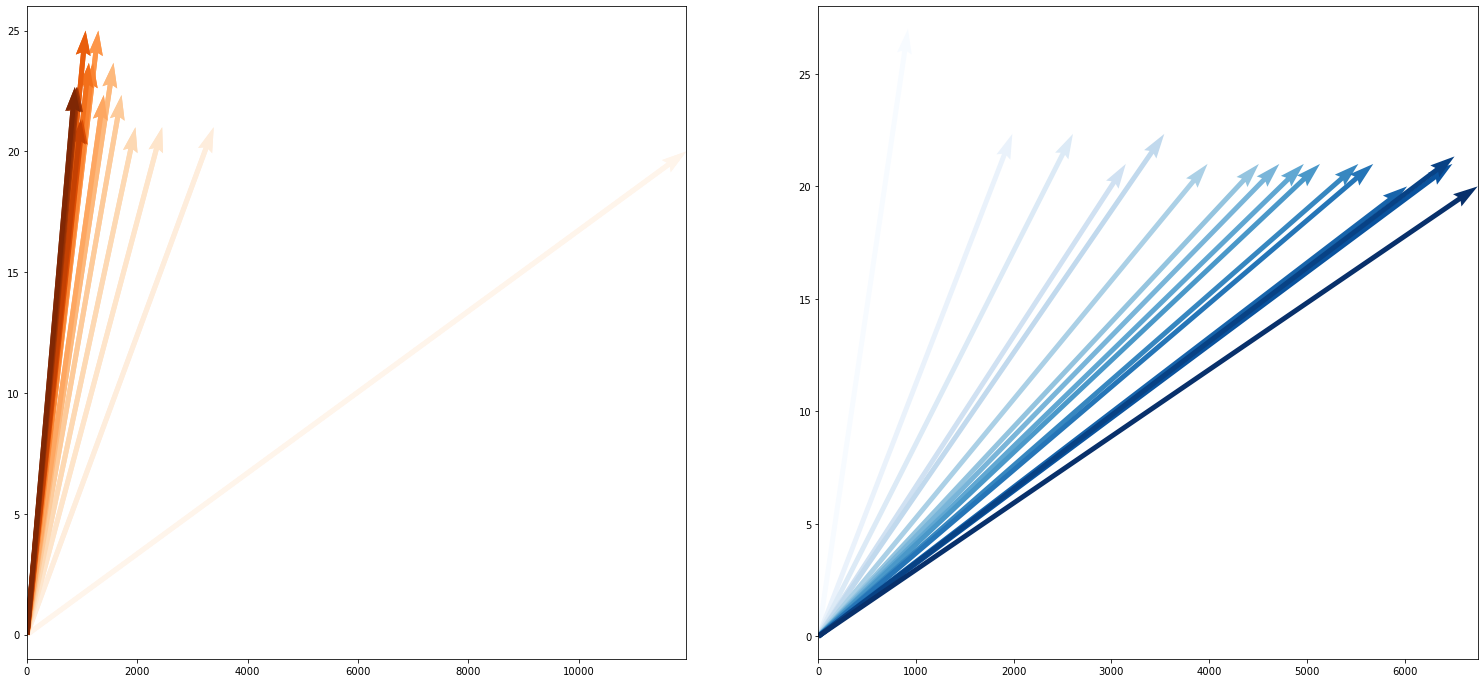

In [119]:
from matplotlib import cm

colors_b = cm.get_cmap('Oranges', len(b_avg))
colors_tau = cm.get_cmap('Blues', len(tau_avg))

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(26,12))

for ind, (vector, variance) in enumerate(zip(b_avg, b_var)):
    ax0.quiver(*vector, angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    
    # Calculate the angle of rotation for the ellipse
    angle = np.arctan2(vector[1], vector[0]) * (180 / np.pi)
    
    ellipse = Ellipse(xy=vector, width=0.05*variance[0], height=0.05*variance[1], edgecolor='none', 
                      angle=angle, facecolor=colors_b(ind), alpha=0.5)
  #  ax0.add_patch(ellipse)

for ind, pair in enumerate(b_avg):
  #  print('b: ', pair)
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    

#for ind, pair in enumerate(tau_avg):
  #  print('tau: ', pair)
#    ax1.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
#               color=colors_tau(ind))
    
for ind, (vector, variance) in enumerate(zip(tau_avg, tau_var)):
    ax1.quiver(*vector, angles='xy', scale_units='xy', scale=1, color=colors_tau(ind))
    
    # Calculate the angle of rotation for the ellipse
    angle = np.arctan2(vector[1], vector[0]) * (180 / np.pi)
    
    ellipse = Ellipse(xy=vector, width=0.1*variance[0], height=0.1*variance[1], edgecolor='none', 
                      angle=angle, facecolor=colors_tau(ind), alpha=0.5)
 #   ax1.add_patch(ellipse)

# Set axis limits based on the vectors
ax0.set_xlim([-1, np.max(b_avg[:,0])+1])
ax0.set_ylim([-1, np.max(b_avg[:,1])+1])

ax1.set_xlim([-1, np.max(tau_avg[:,0])+1])
ax1.set_ylim([-1, np.max(tau_avg[:,1])+1])

In [120]:
b_avg

array([[11954.66666667,    20.        ],
       [ 3385.        ,    21.        ],
       [ 2450.66666667,    21.        ],
       [ 1966.        ,    21.        ],
       [ 1714.33333333,    22.33333333],
       [ 1568.66666667,    23.66666667],
       [ 1391.66666667,    22.33333333],
       [ 1293.33333333,    25.        ],
       [ 1198.66666667,    23.66666667],
       [ 1122.66666667,    23.66666667],
       [ 1062.33333333,    25.        ],
       [ 1012.        ,    21.33333333],
       [  978.66666667,    21.33333333],
       [  924.        ,    22.66666667],
       [  899.33333333,    22.66666667],
       [  868.        ,    22.66666667]])

In [121]:
tau_avg

array([[ 917.        ,   27.        ],
       [1985.        ,   22.33333333],
       [2605.33333333,   22.33333333],
       [3146.33333333,   21.        ],
       [3540.33333333,   22.33333333],
       [3983.33333333,   21.        ],
       [4508.66666667,   21.        ],
       [4718.        ,   21.        ],
       [4968.66666667,   21.        ],
       [5134.33333333,   21.        ],
       [5527.        ,   21.        ],
       [5679.33333333,   21.        ],
       [6025.33333333,   20.        ],
       [6489.33333333,   21.        ],
       [6511.33333333,   21.33333333],
       [6748.        ,   20.        ]])